In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics, ensemble, model_selection

if __name__=='__main__':
    df=pd.read_csv('mobile_train.csv')
    X, y=df.drop('price_range', axis=1), df['price_range'].values
    clf=ensemble.RandomForestClassifier(n_jobs=-1)
    param_grid={"n_estimators": [100, 200, 250, 300, 400, 500],
                "max_depth": [1, 2, 5, 7, 11, 15],
                "criterion": ["gini", "entropy"]}
    
    model=model_selection.GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1,
        cv=5)
    model.fit(X, y)
    
    print(f'Best Score: {model.best_score_}')
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")

Best Score: 0.8885
	criterion: entropy
	max_depth: 15
	n_estimators: 300


In [6]:
import numpy as np
import pandas as pd
from sklearn import metrics, ensemble, model_selection

if __name__=='__main__':
    df=pd.read_csv('mobile_train.csv')
    X, y=df.drop('price_range', axis=1), df['price_range'].values
    clf=ensemble.RandomForestClassifier(n_jobs=-1)
    param_grid={"n_estimators": np.arange(100, 1500, 100),
                "max_depth": np.arange(1, 31),
                "criterion": ["gini", "entropy"]}
    
    model=model_selection.RandomizedSearchCV(
        estimator=clf,
        n_iter=30,
        param_distributions=param_grid,
        scoring='accuracy',
        n_jobs=-1,
        cv=5)
    model.fit(X, y)
    
    print(f'Best Score: {model.best_score_}')
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")

Best Score: 0.8875
	criterion: entropy
	max_depth: 16
	n_estimators: 400


In [18]:
from functools import partial
from sklearn import ensemble, metrics, model_selection
from skopt import gp_minimize, space

def optimize(params, param_names, x, y):
    params=dict(zip(param_names, params))
    model=ensemble.RandomForestClassifier(**params)
    kf=model_selection.StratifiedKFold(5)
    acc_list=[]
    for tr, val in kf.split(X=x, y=y):
        xtrain, xtest, ytrain, ytest=x.iloc[tr, :], x.iloc[val, :], y[tr], y[val]
        model.fit(xtrain, ytrain)
        preds=model.predict(xtest)
        acc_list.append(metrics.accuracy_score(ytest, preds))
    return -1*np.mean(acc_list)

if __name__=='__main__':
    df=pd.read_csv('mobile_train.csv')
    X, y=df.drop('price_range', axis=1), df['price_range'].values
    param_space=[
        space.Integer(3, 15, name='max_depth'),
        space.Integer(100, 1500, name='n_estimators'),
        space.Categorical(['gini', 'entropy'], name='criterion'),
        space.Real(.01, 1, prior='uniform', name='max_features')
    ]
    
    param_names=["max_depth", "n_estimators", "criterion", "max_features"]
    
    opt_func=partial(optimize, param_names=param_names, x=X, y=y)
    res=gp_minimize(opt_func, dimensions=param_space, n_calls=15, n_initial_points=10, verbose=10)
    
    best_params=dict(zip(param_names, res.x))
    print(best_params)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 25.5554
Function value obtained: -0.8855
Current minimum: -0.8855
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.9977
Function value obtained: -0.8695
Current minimum: -0.8855
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.6030
Function value obtained: -0.8625
Current minimum: -0.8855
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.0255
Function value obtained: -0.7750
Current minimum: -0.8855
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 18.2984
Function value obtained: -0.8380
Current minimum: -0.8855
Iteration No: 6 starte

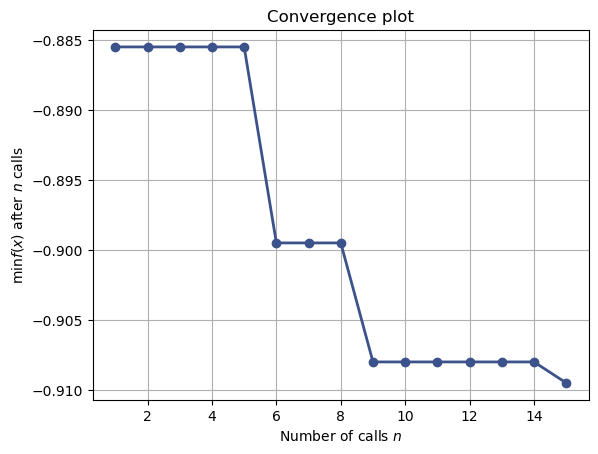

In [20]:
from skopt.plots import plot_convergence

plot_convergence(res);

In [26]:
from functools import partial
from sklearn import ensemble, metrics, model_selection
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope


def optimize(params, x, y):
    model=ensemble.RandomForestClassifier(**params)
    kf=model_selection.StratifiedKFold(5)
    acc_list=[]
    for tr, val in kf.split(X=x, y=y):
        xtrain, xtest, ytrain, ytest=x.iloc[tr, :], x.iloc[val, :], y[tr], y[val]
        model.fit(xtrain, ytrain)
        preds=model.predict(xtest)
        acc_list.append(metrics.accuracy_score(ytest, preds))
    return -1*np.mean(acc_list)

if __name__=='__main__':
    df=pd.read_csv('mobile_train.csv')
    X, y=df.drop('price_range', axis=1), df['price_range'].values
    param_space={
        'max_depth': scope.int(hp.quniform('max_depth', 1, 15, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1500, 1)),
        'criterion': hp.choice('criterion', ['gini', 'entropy']),
        'max_features': hp.uniform('max_features', 0, 1)
    }
        
    opt_func=partial(optimize, x=X, y=y)
    trials=Trials()
    hopt=fmin(
        fn=opt_func,
        space=param_space,
        algo=tpe.suggest,
        max_evals=15,
        trials=trials
    )
    print(hopt)

100%|███████████████████████████████████████████████████████████| 15/15 [02:52<00:00, 11.51s/trial, best loss: -0.9055]
{'criterion': 1, 'max_depth': 13.0, 'max_features': 0.8214311594192648, 'n_estimators': 1416.0}
